In [1]:
import os
import numpy as np

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
from tensorflow import keras
tf.config.set_visible_devices([], 'GPU')
print("Using CPU only.")


2024-12-10 06:44:17.436535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733813057.452855 3518056 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733813057.457903 3518056 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 06:44:17.474740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using CPU only.


2024-12-10 06:44:18.906637: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-10 06:44:18.906671: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: 17185eb77f87
2024-12-10 06:44:18.906679: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: 17185eb77f87
2024-12-10 06:44:18.906770: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2024-12-10 06:44:18.906789: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2024-12-10 06:44:18.906795: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [1]:
!python --version

Python 3.11.0rc1


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2024-12-10 06:45:08.396287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733813108.413118 3519421 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733813108.418283 3519421 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-10 06:45:08.435739: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12751134984404736986
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10705371136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 768168299629357180
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:41:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10735714304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13927396648400294165
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:61:00.0, compute capability: 8.6"
xla_global_id: 2144165316
]


I0000 00:00:1733813110.256789 3519421 gpu_device.cc:2022] Created device /device:GPU:0 with 10209 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1733813110.257376 3519421 gpu_device.cc:2022] Created device /device:GPU:1 with 10238 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:61:00.0, compute capability: 8.6


In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

載入檔案

In [4]:
import os
import shutil
if (not os.path.isdir("已分類垃圾")):
    os.system("gdown https://drive.google.com/uc?id=1eTMU44txJ6rMJpASQl17qW9qyNPWczvt")
    shutil.unpack_archive("已分類垃圾.zip", ".")

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(input_dir, output_dir, val_ratio=0.2):
    # 確保目標目錄存在
    os.makedirs(output_dir, exist_ok=True)

    # 遍歷每個類別
    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue  # 跳過非資料夾的項目

        # 獲取該類別中的所有圖片檔案
        images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

        # 分割為訓練集和驗證集
        train_images, val_images = train_test_split(images, test_size=val_ratio, random_state=42)

        # 創建訓練和驗證目錄
        train_dir = os.path.join(output_dir, "train", class_name)
        val_dir = os.path.join(output_dir, "val", class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # 複製圖片到對應目錄
        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, img))
        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, img))

    print("數據集分割完成！")

# 使用範例
input_dir = "已分類垃圾"  # 原始數據集目錄
output_dir = "已分類垃圾(已分割)"  # 分割後的目錄

split_dataset(input_dir, output_dir)


數據集分割完成！


In [6]:
base_dir = '已分類垃圾(已分割)'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 設定資料增強與重新縮放
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # 將像素值縮放到 [0, 1]
    shear_range=10,       # 隨機應用剪切變換
    zoom_range=0.2,       # 隨機縮放
    horizontal_flip=True  # 隨機水平翻轉
)

# 建立訓練集生成器
train_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),   # 調整圖片大小
    batch_size=10,          # 批次大小
    class_mode="categorical"  # 使用多類別分類（由於有八個類別）
)

# 建立驗證集生成器
val_set = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),   # 調整圖片大小
    batch_size=10,          # 批次大小
    class_mode="categorical"  # 使用多類別分類
)

Found 12850 images belonging to 8 classes.
Found 12850 images belonging to 8 classes.


In [8]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_set = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(128, 128),
    batch_size=10,
    class_mode="categorical")

Found 3215 images belonging to 8 classes.


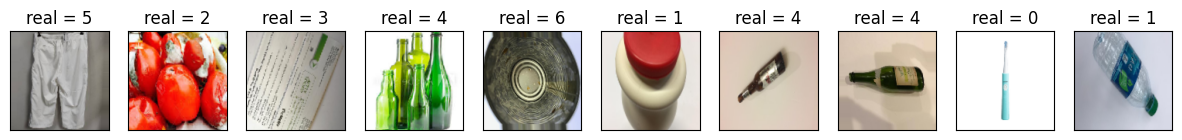

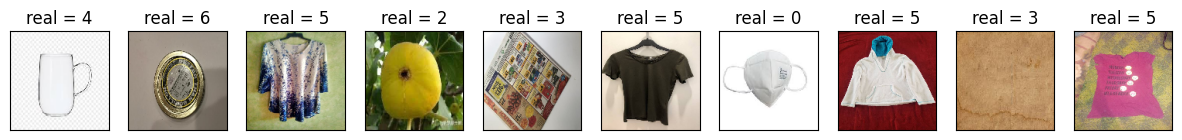

In [9]:
import os

if not os.path.isdir("HappyML"):
  os.system("git clone https://github.com/cnchi/HappyML.git")
# Validate the Success of Image Loading
import HappyML.model_drawer as md

# Print the first 10 images of Training Set
for data, label in train_set:
    md.show_first_n_images(x_ary=data, y_real=np.argmax(label, axis=1), first_n=10, font_size=12)
    break

# Print the first 10 images of Testing Set
for data, label in test_set:
    md.show_first_n_images(x_ary=data, y_real=np.argmax(label, axis=1), first_n=10, font_size=12)
    break

In [10]:
print("訓練集類別索引：", train_set.class_indices)
print("驗證集類別索引：", val_set.class_indices)
print("測試集類別索引：", test_set.class_indices)


訓練集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}
驗證集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}
測試集類別索引： {'一般 general': 0, '塑膠 plastic': 1, '廚餘 food_waste': 2, '廢紙 waste_paper': 3, '玻璃 glass': 4, '衣服類 clothes (Textiles)': 5, '鐵鋁金屬 iron alumium': 6, '電池類 battery': 7}


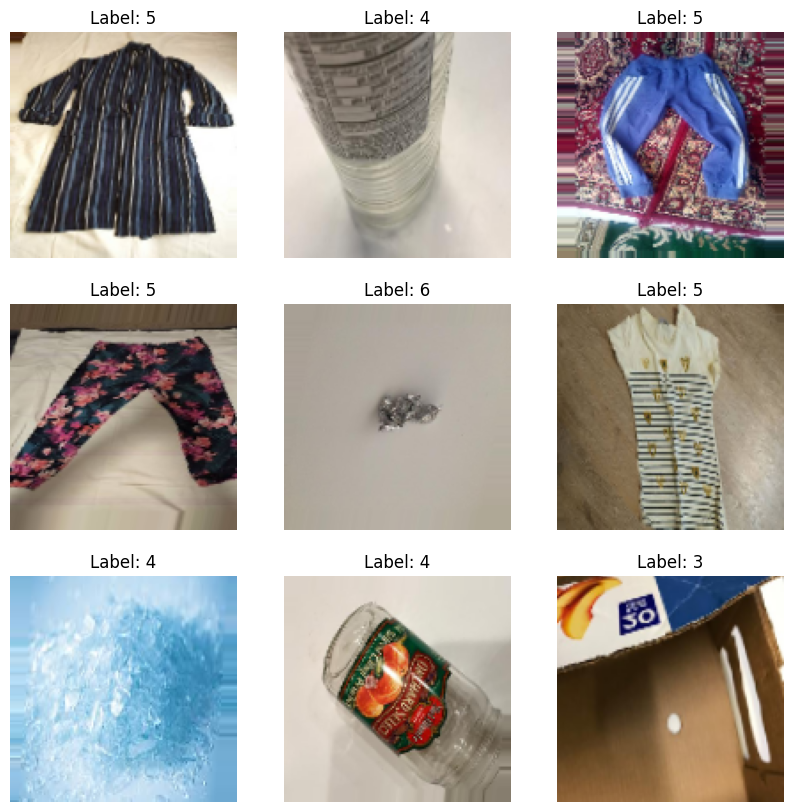

In [11]:
# 從訓練集隨機取一批圖片
images, labels = next(train_set)

# 顯示圖片
plt.figure(figsize=(10, 10))
for i in range(9):  # 顯示前9張圖片
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {np.argmax(labels[i])}")
    plt.axis("off")
plt.show()


In [12]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Create TensorBoard log directory
import os
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

In [13]:
# Start the TensorBoard
%tensorboard --logdir logs --host=0.0.0.0 --port=6666 --path_prefix "/tensorboard"

# --- For TensorBoard 403 Error ---
# Start the TensorBoard (Ignore the errors)
# %tensorboard --logdir logs --host=127.0.0.1 --port=6006 --load_fast=false

# Workaround for loading TensorBoard
# from google.colab import output
# output.serve_kernel_port_as_window(6006, path="")

Launching TensorBoard...

In [14]:
from IPython.display import IFrame
IFrame(src='/tensorboard', width='100%', height='800px')

In [15]:
image_size = 128

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Resizing(image_size, image_size))

inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
for layer in inceptionV3.layers:
    layer.trainable = False
# Fine-tune the top layers of InceptionV3
for layer in inceptionV3.layers[-15:]:  # Unfreeze the last 10 layers
    layer.trainable = True

model.add(inceptionV3)

# Add a Global Average Pooling layer
model.add(GlobalAveragePooling2D())

# Output layer
model.add(layers.Dense(units=8, activation="softmax"))

# Compile
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

I0000 00:00:1733813118.414743 3519421 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10209 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:41:00.0, compute capability: 8.6
I0000 00:00:1733813118.415075 3519421 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10238 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:61:00.0, compute capability: 8.6


In [17]:
inceptionV3.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 63, 63,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 61, 61,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 30, 30,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 30, 30,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 394,880 (1.51 MB)

 Non-trainable params: 21,407,904 (81.66 MB)

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 394,880 (1.51 MB)

 Non-trainable params: 21,407,904 (81.66 MB)

In [19]:
nowdatetime = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", nowdatetime)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [20]:
# Training Model
epochs_metrics = model.fit(train_set, validation_data=val_set, batch_size=32, epochs=40, callbacks=[tensorboard_callback])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1733813124.965586 3520630 service.cc:148] XLA service 0x7106bc002dd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733813124.965615 3520630 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1733813124.965619 3520630 service.cc:156]   StreamExecutor device (1): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-12-10 06:45:25.179636: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733813126.126025 3520630 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1285 ━━━━━━━━━━━━━━━━━━━━ 3:36:57 10s/step - accuracy: 0.1000 - loss: 4.0113

I0000 00:00:1733813130.585476 3520630 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1285/1285 ━━━━━━━━━━━━━━━━━━━━ 82s 56ms/step - accuracy: 0.3522 - loss: 2.0116 - val_accuracy: 0.6237 - val_loss: 1.1445
Epoch 2/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.6309 - loss: 1.1308 - val_accuracy: 0.7305 - val_loss: 0.8307
Epoch 3/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - accuracy: 0.7108 - loss: 0.8867 - val_accuracy: 0.7747 - val_loss: 0.6945
Epoch 4/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - accuracy: 0.7457 - loss: 0.7847 - val_accuracy: 0.7973 - val_loss: 0.6158
Epoch 5/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 67s 52ms/step - accuracy: 0.7784 - loss: 0.6824 - val_accuracy: 0.8178 - val_loss: 0.5603
Epoch 6/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.7940 - loss: 0.6284 - val_accuracy: 0.8274 - val_loss: 0.5202
Epoch 7/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8060 - loss: 0.6010 - val_accuracy: 0.8410 - val_loss: 0.4806
Epoch 8/40
1285/1285 ━━━━━━━━━━━━━━━━━━━━ 68s 53ms/step - accuracy: 0.8226 - loss: 0.54

In [21]:
model.save(f'trained-{nowdatetime}.keras')

In [22]:
images, labels = next(test_set)

In [23]:
Y_pred = np.argmax(pred, axis=1)
Y_pred

NameError: name 'pred' is not defined

In [ ]:
Y_labels = np.argmax(labels, axis=1)
Y_labels

In [ ]:
# 從訓練集隨機取一批圖片
images, labels = next(test_set)
pred = model.predict(images)
Y_pred = np.argmax(pred, axis=1)
Y_labels = np.argmax(labels, axis=1)

# 顯示圖片
plt.figure(figsize=(10, 10))
for i in range(9):  # 顯示前9張圖片
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {Y_labels[i]}\nPredict: {Y_pred[i]}")
    plt.axis("off")
plt.show()

In [ ]:
# Model Evaluation
test_loss, test_acc = model.evaluate(test_set)
print("Loss of Test:", test_loss)
print("Accuracy of Test:", test_acc)